In [22]:
import time

from FNFTpy import nsev
from FNFTpy import nsev_inverse, nsev_inverse_xi_wrapper
import numpy as np
import pandas as pd
import random
import timeit
from tqdm import tqdm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift

import matplotlib.pyplot as plt
import matplotlib

from importlib import reload

import ssfm
reload(ssfm)

import signal_generation as sg
reload(sg)

import nft_analyse as nft
reload(nft)

<module 'nft_analyse' from '/home/esf0/PycharmProjects/nn_essential/nft_analyse.py'>

In [26]:
D = 2 ** 12
# M = 2*D
M = D
Tmax = 32
tvec = np.linspace(-Tmax, Tmax, D)
# calculate suitable frequency bonds (xi)
rv, xi = nsev_inverse_xi_wrapper(D, tvec[0], tvec[-1], M)
xivec = xi[0] + np.arange(M) * (xi[1] - xi[0]) / (M - 1)

temp_a = np.pi / (2. * Tmax) * (D-1)
print(temp_a, temp_a - temp_a / M)
print(xi[1] - xi[0])

# analytic field: chirp-free N=2.2 Satsuma-Yajima pulse
q = 5.2 / np.cosh(tvec)

# semi-analytic nonlinear spectrum
bound_states = np.array([0.7j, 1.7j])
disc_norming_const_ana = [1.0, -1.0]
cont_b_ana = 0.587783 / np.cosh(xivec * np.pi) * np.exp(1.0j * np.pi)

# call the function
res = nsev_inverse(xivec, tvec, cont_b_ana, bound_states, disc_norming_const_ana, cst=1, dst=0)

# compare result to analytic function
print("\n\nnsev-inverse example: Satsuma-Yajima N=2.2")
print("Difference analytic - numeric: sum((q_ana-q_num)**2) = %.2e  (should be approx 0) "%np.sum(np.abs(q-res['q'])**2))

201.0128424445344 200.96376704354697
200.963767043547


nsev-inverse example: Satsuma-Yajima N=2.2
Difference analytic - numeric: sum((q_ana-q_num)**2) = 1.15e+03  (should be approx 0) 


In [27]:
# Check pjt
start_point = -0.5 + 0.0j
end_point = 0.5 + 5.0j
contour = nft.get_rect(start_point, end_point, 2 ** 7, 2 ** 7)
a_values, _ = nft.get_scattering_array(q, tvec, contour, type='bo')

In [28]:
print('Start pjt')
# disc_pjt, tracks = nft.pjt_igor(q, tvec, start_point=start_point, end_point=end_point,
#                                 contour=contour, a_values=a_values, type='bo', print_sys_message=True)


disc_pjt, tracks = nft.pjt_igor(q, tvec, start_point=start_point, end_point=end_point, type='bo', print_sys_message=True)

Start pjt
contour and a_values will be calculated.
Time to compute a_coef for contour: 58.50652837753296 s. n_points = 444
jump found! 0j (0.012500000000000067+0j) , orientation: 0
jump found! (0.5+1.8674698795180722j) (0.5+1.8975903614457832j) , orientation: 1
jump found! (0.5+4.307228915662651j) (0.5+4.337349397590361j) , orientation: 1
jump found! (-0.5+4.337349397590361j) (-0.5+4.307228915662651j) , orientation: 3
jump found! (-0.5+1.8975903614457832j) (-0.5+1.8674698795180724j) , orientation: 3
PJT found 5 phase breakpoints
Length =  9
Length =  17
Length =  19
Length =  8
[ 0.        +0.j          0.04196065+2.61539308j -0.00513584+4.65904638j
  0.00513584+3.71612615j -0.04196065+1.69931438j]


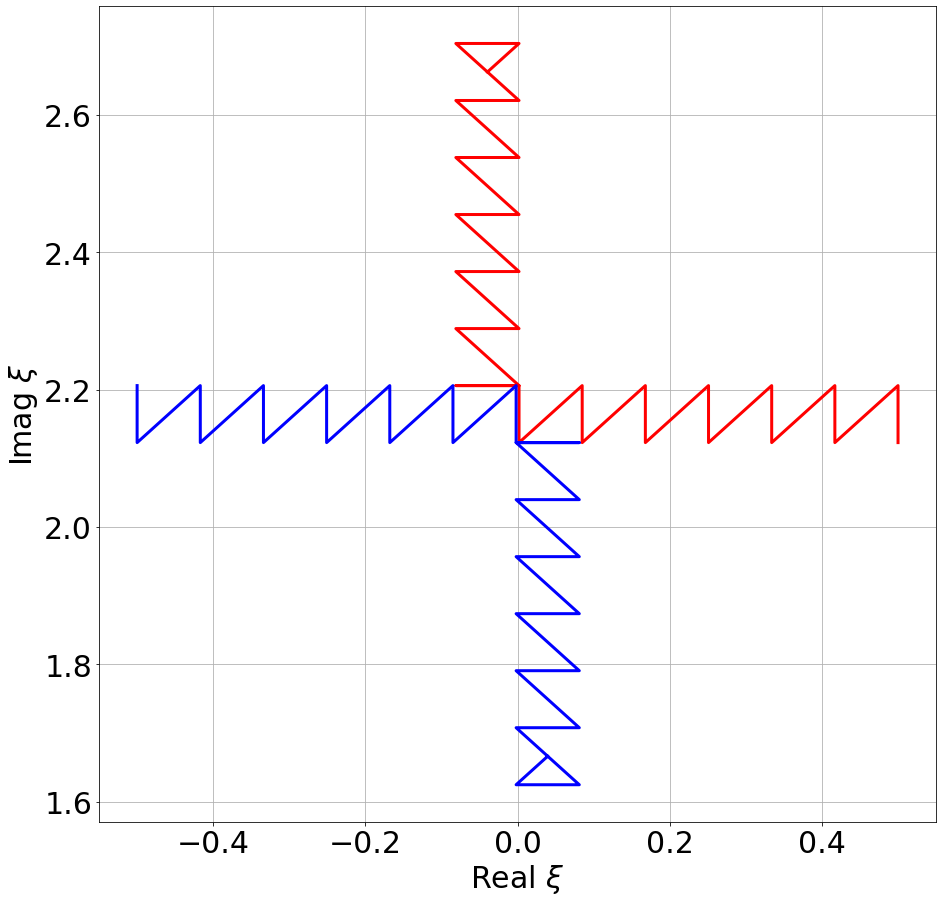

In [58]:
matplotlib.rcParams.update({'font.size': 30})

colors = ['red', 'blue', 'green']
fig, axs = plt.subplots(1, 1, figsize=(15,15))
for i in range(len(tracks)):
    axs.plot(np.real(tracks[i]), np.imag(tracks[i]), colors[i], linewidth=3)
# axs.plot(tvec, np.absolute(q_tib - q), 'blue', linewidth=5)
# axs.plot(tvec * 0.5, np.absolute(q_tib), 'green', linewidth=3)
# axs.set_xlim(-5, 5)
# axs.set_ylim(0, 20)
axs.set_xlabel(r'Real $\xi$')
axs.set_ylabel(r'Imag $\xi$')
axs.grid(True)


In [11]:
for D in [2**10, 2**11, 2**12, 2**13, 2**14]:
    # D = 2 ** 13
    # M = 2*D
    # M = D
    Tmax = 32
    tvec = np.linspace(-Tmax, Tmax, D)

    a = 2.2
    c = 0.0
    q_sech, a_xi_sech, b_xi_sech, xi_discr_sech, b_discr_sech, r_discr_sech, ad_discr_sech = nft.get_sech(
        tvec, xivec, a, c)

    print('b', b_discr_sech)
    print('r', r_discr_sech)

    # Check bi-directional

    # res = nsev(q_sech, tvec, xi[0], xi[-1], M, dst=2)
    # print('b', res['disc_res'])
    # print('r', res['disc_norm'])

    b_xi = []
    r_xi = []
    for j in range(len(xi_discr_sech)):
        b_xi_t, r_xi_t, ad_xi_t = nft.do_bi_direct(q_sech, tvec, xi_discr_sech[j], 'tes4')
        # b_xi += [b_xi_t]
        # r_xi += [r_xi_t]
        print('j:', j, 'b:', abs(b_xi_t - b_discr_sech[j]),
              'r:', abs(r_xi_t - r_discr_sech[j]),
              'ad:', abs(ad_xi_t - ad_discr_sech[j]))
    #
    # b_xi = np.array(b_xi)
    # r_xi = np.array(b_xi)

    # result = nft.do_bi_direct(q_sech, tvec, 0.7j, 'tes4')
    # result2 = nft.do_bi_direct(q_sech, tvec, 1.7j, 'tes4')
    # print(result)
    # print(result2)

b [-1.-6.1232340e-16j  1.+4.8985872e-16j]
r [5.11262951e-15-8.34955762j 1.73227917e-15-3.53628323j]
j: 0 b: 0.001258763651879602 r: 0.010724396617671772 ad: 3.0775616018385854e-06
j: 1 b: 0.00022080364294674304 r: 0.0008258306542447968 ad: 3.5981488316072507e-06
b [-1.-6.1232340e-16j  1.+4.8985872e-16j]
r [5.11262951e-15-8.34955762j 1.73227917e-15-3.53628323j]
j: 0 b: 0.0003146564049998357 r: 0.0026406335832298566 ad: 1.921539717619769e-07
j: 1 b: 4.95877089570218e-05 r: 0.00017816734024478365 ad: 2.2478591954477878e-07
b [-1.-6.1232340e-16j  1.+4.8985872e-16j]
r [5.11262951e-15-8.34955762j 1.73227917e-15-3.53628323j]
j: 0 b: 7.862721928597605e-05 r: 0.0006573389640518457 ad: 1.1999291615882868e-08
j: 1 b: 1.2393393632903482e-05 r: 4.400211540955823e-05 ad: 1.4039103712892853e-08
b [-1.-6.1232340e-16j  1.+4.8985872e-16j]
r [5.11262951e-15-8.34955762j 1.73227917e-15-3.53628323j]
j: 0 b: 1.965016959271093e-05 r: 0.00016412248136177254 ad: 7.496097215176079e-10
j: 1 b: 3.0983449119670325e

In [18]:
dt = tvec[1] - tvec[0]
diff = []
nj = 100
tj = 1
coef = []
for j in range(nj):
    diff += [abs(r_xi_t * np.exp(-1.0j * xi * (j * tj / nj - tj / 2) * dt) - r_discr_sech[1])]
    coef += [(j * tj / nj - tj / 2)]

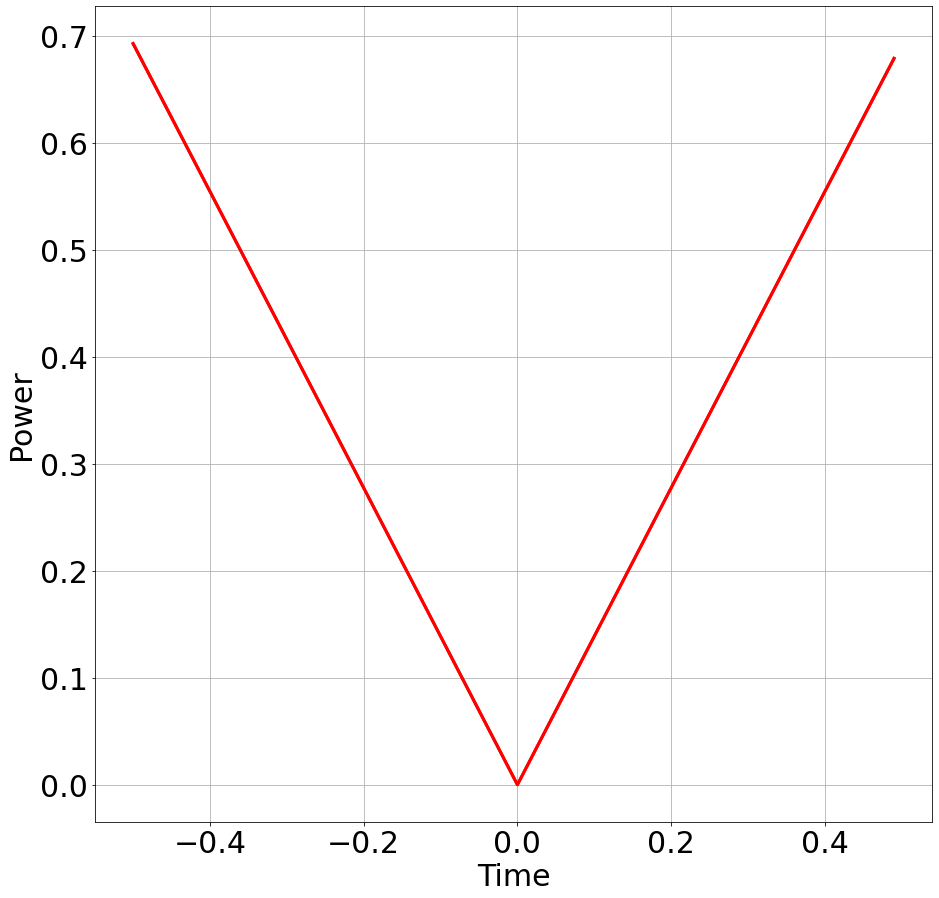

In [19]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(coef, diff, 'red', linewidth=3)
# axs.plot(tvec, np.absolute(q_tib - q), 'blue', linewidth=5)
# axs.plot(tvec * 0.5, np.absolute(q_tib), 'green', linewidth=3)
# axs.set_xlim(-5, 5)
# axs.set_ylim(0, 20)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

In [32]:
q = 2.0 * (5.2 / np.cosh(tvec) + 1.2 / np.cosh((tvec + 1) * 3) + 2.4 / np.cosh((tvec - 1) * 3))
res = nsev(q, tvec, xi[0], xi[-1], M, dst=2, cst=2)
rd_test = res['disc_res']
bd_test = res['disc_norm']
r_test = res['cont_ref']
a_test = res['cont_a']
b_test = res['cont_b']
xi_d = res['bound_states']
print(xi_d)

[ 2.24207754e-44 +1.36831671j  3.30607786e-38 +0.30353366j
 -1.05826060e-41 +2.50661029j -9.40395481e-38 +3.68606642j
  1.88079096e-36 +4.86064314j -3.00926554e-36 +5.987249j
 -3.67341985e-40 +7.03500516j -2.31111593e-33 +7.98385967j
  6.90253292e-30 +8.8150679j   1.29422492e-31 +9.51623733j
  2.33176064e-42+10.1436612j   4.33334237e-34+10.76398403j
  1.21075918e-36+11.30888187j]


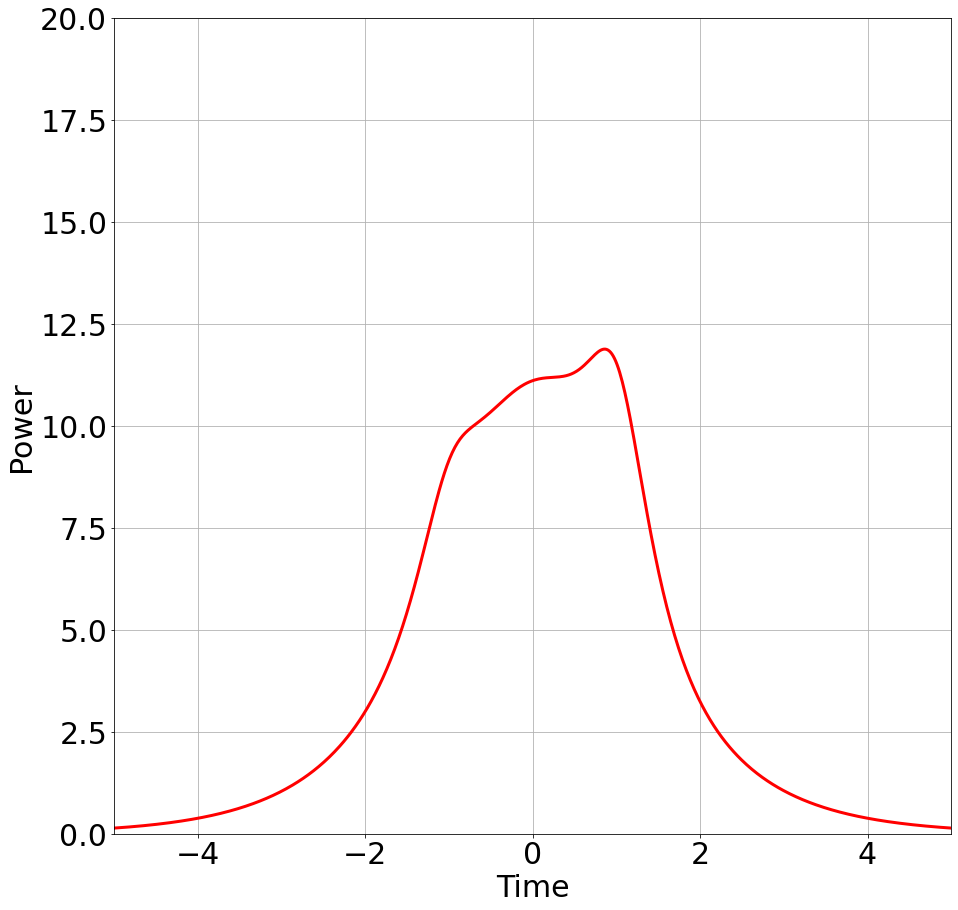

In [33]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(tvec, np.absolute(q), 'red', linewidth=3)
# axs.plot(tvec, np.absolute(q_tib - q), 'blue', linewidth=5)
# axs.plot(tvec * 0.5, np.absolute(q_tib), 'green', linewidth=3)
axs.set_xlim(-5, 5)
axs.set_ylim(0, 20)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

In [34]:
import nft_analyse as nft
reload(nft)


# Check itib

omega_r = nft.get_omega_continuous(np.conj(b_test) / a_test, xivec, tvec)
omega_d = nft.get_omega_discrete(rd_test / bd_test / bd_test, xi_d, tvec)

q_tib = nft.make_itib(omega_d + omega_r, tvec)

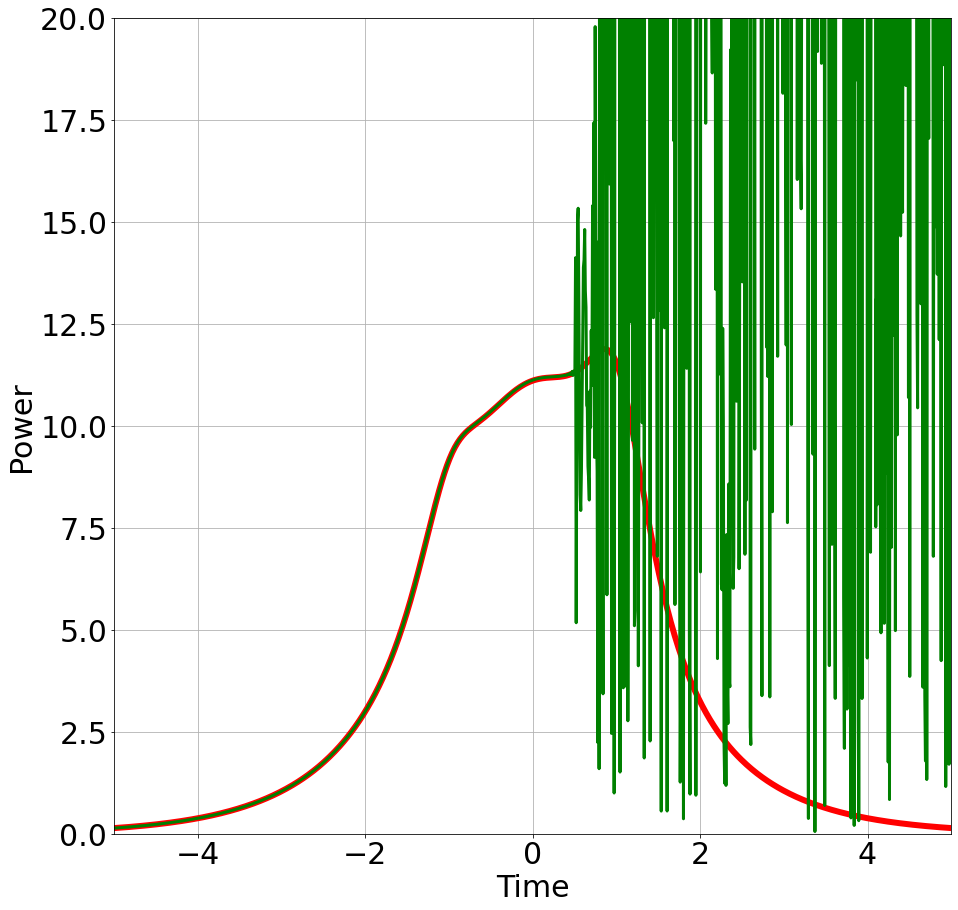

In [36]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(tvec, np.absolute(q), 'red', linewidth=6)
# axs.plot(tvec, np.absolute(q_tib - q), 'blue', linewidth=5)
axs.plot(tvec * 0.5, np.absolute(q_tib), 'green', linewidth=3)
axs.set_xlim(-5, 5)
axs.set_ylim(0, 20)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

In [106]:
import nft_analyse as nft
reload(nft)

a = 18.2
c = 0.2
q_sech, a_xi_sech, b_xi_sech, xi_discr_sech, b_discr_sech, r_discr_sech, ad_discr_sech = nft.get_sech(
    tvec, xivec, a, c)

print(xi_discr_sech)
print(b_discr_sech)
print(r_discr_sech)
print(ad_discr_sech)

res = nsev(q_sech, tvec, xi[0], xi[-1], M, dst=2, cst=2)
rd_test_sh = res['disc_res']
bd_test_sh = res['disc_norm']
r_test_sh = res['cont_ref']
a_test_sh = res['cont_a']
b_test_sh = res['cont_b']
xi_d_sh = res['bound_states']

[0.+17.69972527j 0.+16.69972527j 0.+15.69972527j 0.+14.69972527j
 0.+13.69972527j 0.+12.69972527j 0.+11.69972527j 0.+10.69972527j
 0. +9.69972527j 0. +8.69972527j 0. +7.69972527j 0. +6.69972527j
 0. +5.69972527j 0. +4.69972527j 0. +3.69972527j 0. +2.69972527j
 0. +1.69972527j 0. +0.69972527j]
[-0.99115063+0.13274195j  0.99262711-0.12120818j -0.99404783+0.10894454j
  0.99539522-0.09585586j -0.99664654+0.08182713j  0.9977719 -0.06671758j
 -0.99873151+0.05035243j  0.99947138-0.0325109j  -0.99991668+0.01290853j
  0.99996102+0.00882992j -0.99944827-0.03321378j  0.99814026+0.06095912j
 -0.99565503-0.09311854j  0.99133845+0.13133197j -0.9839642 -0.17836606j
  0.97090598+0.239461j   -0.94517425-0.32656643j  0.87806685+0.47853798j]
[-1.43888127e+10-1.07437631e+11j -1.09801900e+11-8.99216101e+11j
 -3.76472939e+11-3.43506983e+12j -7.63794755e+11-7.93146732e+12j
 -1.01446972e+12-1.23561432e+13j -9.18004357e+11-1.37288986e+13j
 -5.65375770e+11-1.12141272e+13j -2.22514240e+11-6.84067875e+12j
 -4.045

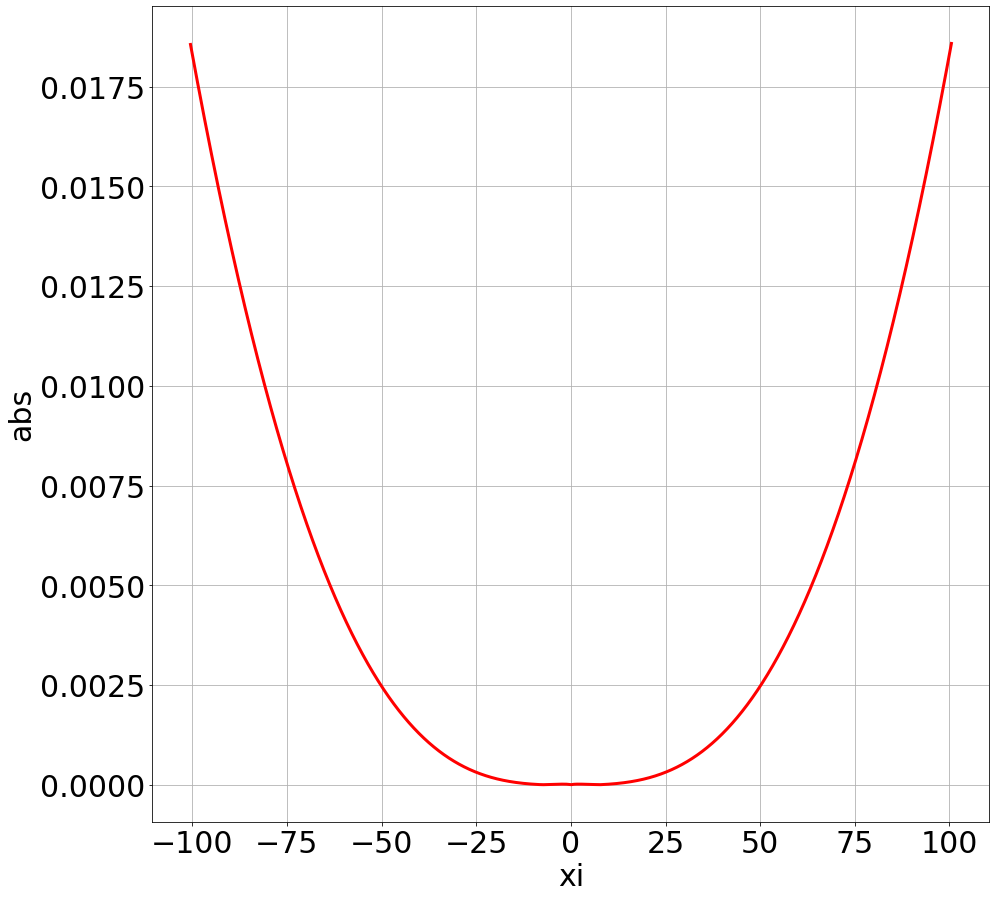

In [72]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
# axs.plot(xivec, np.absolute(b_test_sh), 'red', linewidth=3)
axs.plot(xivec, np.absolute(a_test_sh - a_xi_sech), 'red', linewidth=3)
# axs.plot(xivec, np.absolute(b_xi_sech), 'green', linewidth=3)
# axs.set_xlim(-5, 5)
# axs.set_ylim(0, 20)
axs.set_xlabel('xi')
axs.set_ylabel('abs')
axs.grid(True)

In [107]:
import nft_analyse as nft
reload(nft)


# Check itib

omega_r = get_omega_continuous(b_xi_sech / a_xi_sech, xivec, tvec)
omega_d = get_omega_discrete(r_discr_sech, xi_discr_sech, tvec)

q_tib = nft.make_itib(omega_d + omega_r, tvec)

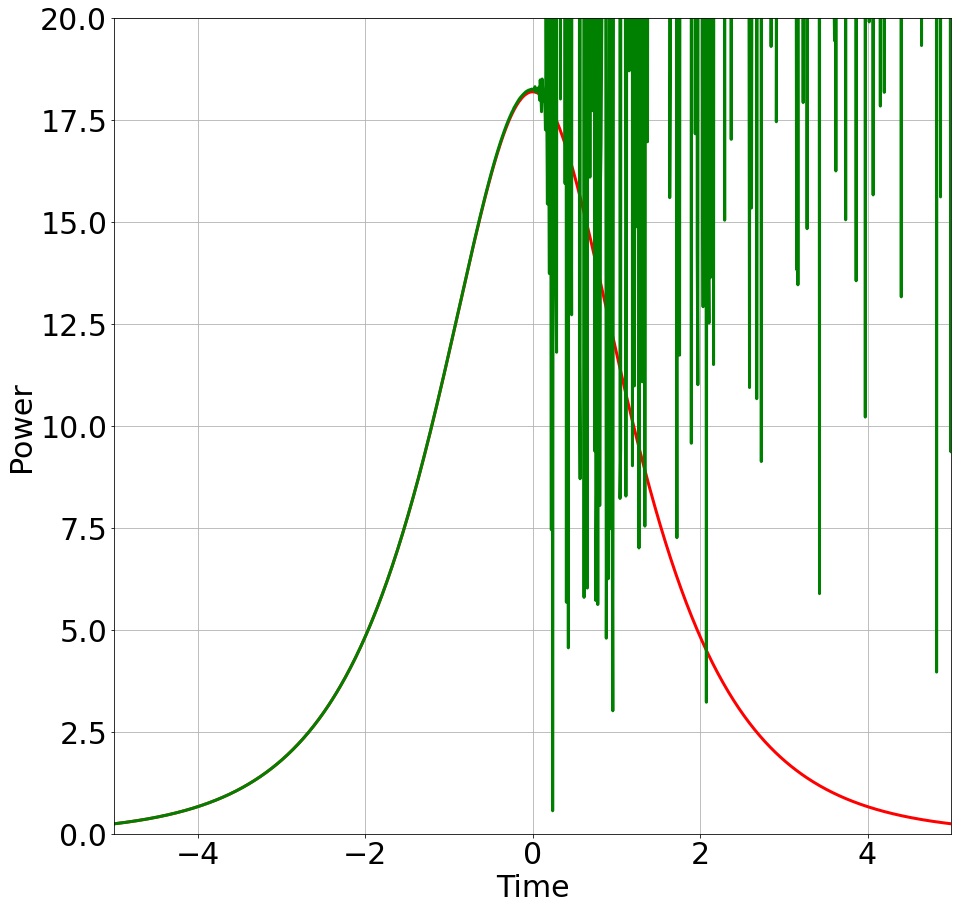

In [108]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(tvec, np.absolute(q_sech), 'red', linewidth=3)
# axs.plot(tvec, np.absolute(q_tib - q), 'blue', linewidth=5)
axs.plot(tvec * 0.5, np.absolute(q_tib), 'green', linewidth=3)
axs.set_xlim(-5, 5)
axs.set_ylim(0, 20)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)



In [16]:
print(nft.get_scattering(q, tvec, 0.7j, type='tes4d'))
print(nft.get_scattering(q, tvec, 1.7j, type='tes4d'))

(array([-5.44490292e-14+0.j]), array([1.+0.j]), array([0.+0.28278278j]))
(array([4.8904941e-14+0.j]), array([-388.39141064+0.j]), array([0.-0.11976682j]))


In [44]:
q_sech, a_xi_sech, b_xi_sech, xi_discr_sech, b_discr_sech, r_discr_sech, ad_discr_sech = nft.get_sech(
    tvec, xivec, 2.2, 0.0)

print(xi_discr_sech)
print(b_discr_sech)
print(r_discr_sech)
print(ad_discr_sech)

[0.+1.7j 0.+0.7j]
[-1.-6.1232340e-16j  1.+4.8985872e-16j]
[ 5.11262951e-15-8.34955762j -1.73227917e-15+3.53628323j]
[0.-0.11976682j 0.-0.28278278j]


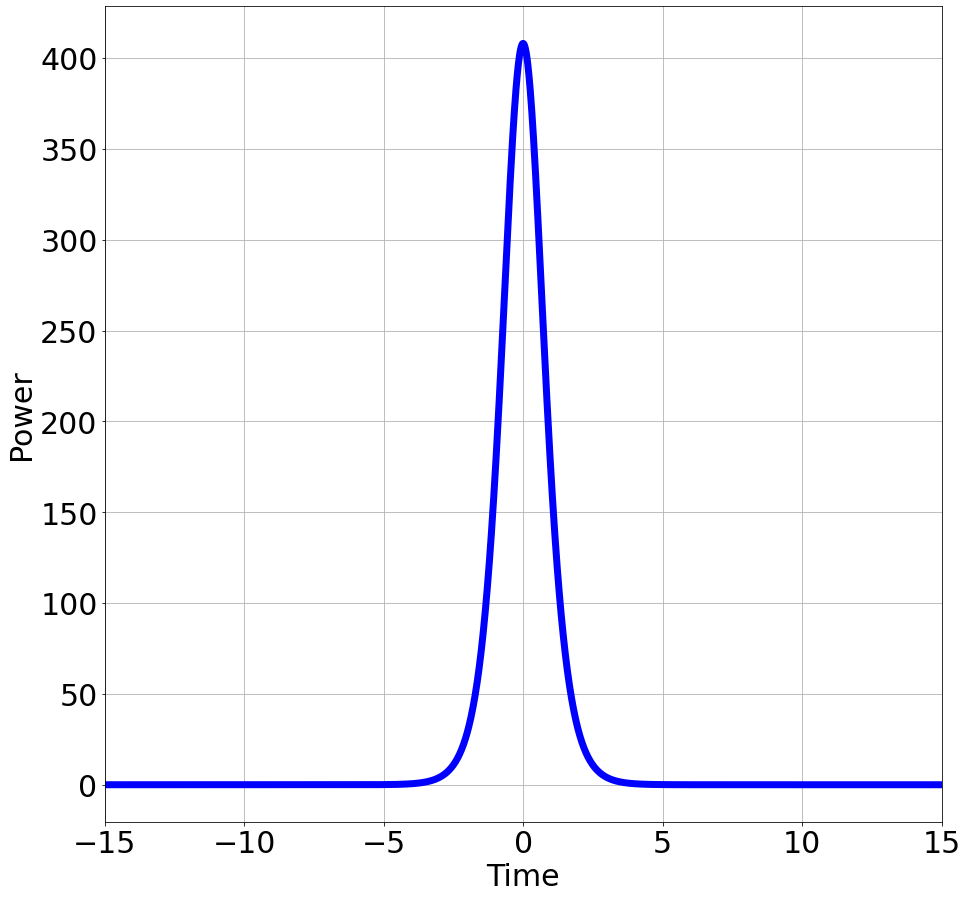

### Here we start propagation

Create signal


In [270]:
# Create test signal

xi_upsampling = 1
n_t = 2 ** 12
n_xi = xi_upsampling * n_t
t_span = 128
t = np.linspace(-t_span, t_span, n_t)
print(t[0], t[-1])
# calculate suitable frequency bonds (xi)
rv, xi_val = nsev_inverse_xi_wrapper(n_t, t[0], t[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)

# q_ampl = 0.5 * 3 / 100
q_ampl = 0.15 + 0.1j
q = q_ampl * (5.2 / np.cosh(t) + 1.2 / np.cosh((t + 1) * 3) + 2.4 / np.cosh((t - 1) * 3)) * np.exp(1j * 0.1 * t)
print(len(q))

-128.0 128.0
4096


In [67]:
import signal_generation as sg
reload(sg)

# Create real signal
# signal parameters
mod_type = "16qam"
n_car = 1
t_symb = 1.

num_symbols = 2 ** 9
np_symb = 16
n_lateral_symbols = 2 ** 6
n_lateral = n_lateral_symbols * np_symb
# n_lateral = 0
p_ave = sg.dbm_to_nd(-5, t_symb=14.8)
print("p_ave:", p_ave)
roll_off = 0.1
# calc_type = 1
xi_upsampling = 4

dt = t_symb / np_symb

# generate bit sequence
n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
random.seed(0)
bits = random.getrandbits(n_bits)
data = "{0:b}".format(int(bits))
if len(data) < n_bits:
    data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

# create signal and set power
signal = sg.get_wdm_signal(data, t_symb, np_symb, sg.rcos, [t_symb, roll_off],
                           n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
q = sg.set_average_power(signal, dt, p_ave, len(signal) // 2 - n_lateral)
n_add = (sg.round_power_of_2(1, len(q)) - len(q)) // 2
print(n_add * dt)
q = sg.add_lateral(q, n_add)
print(len(q))

# so finally we add to signal n_lateral + n_add points for each side

# create time and spectrum
n_t = len(q)
# t = np.array([(i - (n_t - 1) / 2) * dt for i in range(n_t)])
t = np.array([(i - n_t / 2) * dt for i in range(n_t)])
t_span = t[-1] - t[0]
print(t_span, dt * n_t)

n_xi = xi_upsampling * n_t

rv, xi_val = nsev_inverse_xi_wrapper(n_t, t[0], t[-1], n_xi)
xi = xi_val[0] + np.arange(n_xi) * (xi_val[1] - xi_val[0]) / (n_xi - 1)

# xi_span = np.pi / (2. * dt)
# dxi = xi_span / n_signal
# xi = np.linspace(-xi_span / 2., xi_span / 2. - dxi, n_signal)

p_ave: 0.0040915578108268276
192.0
16384
1023.9375 1024.0


In [68]:
points_orig = np.array(sg.get_constellation_point(data, type=mod_type))
points_restored = np.array(sg.get_points_wdm(q, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral + n_add))
constellation_scale = sg.get_scale_coef(points_restored, mod_type)
points_restored = sg.get_scale_coef(points_restored, mod_type) * points_restored
points_diff = points_orig - points_restored
print(len(points_orig), len(points_restored))
print(np.max(np.absolute(points_orig - points_restored)))

512 512
1.5700924586837752e-16


In [ ]:
print(q)

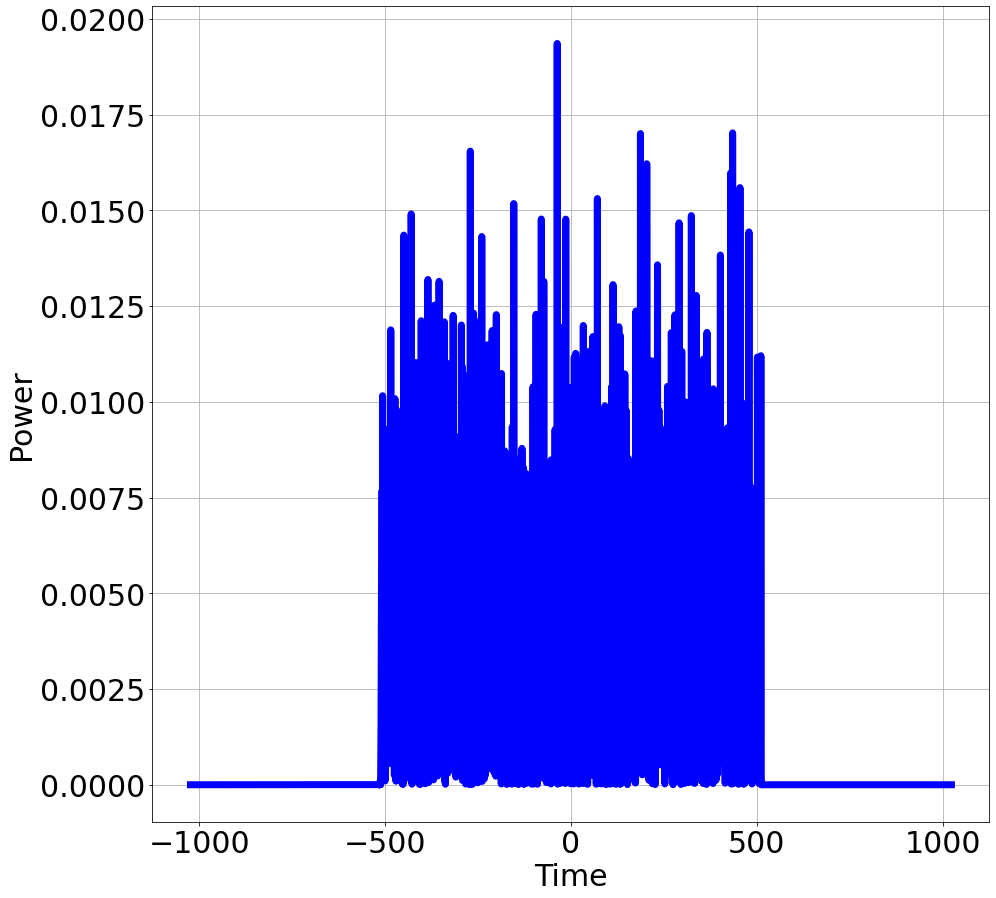

In [57]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t, np.power(np.absolute(q), 2), 'blue', linewidth=7)
# axs.set_xlim(-Tmax, Tmax)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)



In [69]:

# res = nsev(q, t, xi[0], xi[-1], n_xi, dst=2, cst=2, K=512, niter=20, ref=1)
res = nsev(q, t, xi[0], xi[-1], n_xi, dst=2, cst=2, K=1024)
rd_test = res['disc_res']
bd_test = res['disc_norm']
r_test = res['cont_ref']
a_test = res['cont_a']
b_test = res['cont_b']
xi_d = res['bound_states']
# print(xi_d)

# ad_test = bd_test / rd_test

In [70]:
# print(len(rd_test), rd_test)
print(len(bd_test))
print(bd_test)

123
[ 1.11737098e+00+0.59406471j -1.21653407e+00+1.15370804j
  3.98221905e-01-0.93831485j  7.63493574e-01-0.59427174j
  1.39833426e+00+0.58878198j  1.02674236e-01-1.76256207j
  8.15182500e-01-0.9516106j  -4.44864182e-01-0.2065474j
  5.49764995e-01-0.56997016j -2.39321476e-01+0.81030313j
 -2.24029974e-01+0.86780416j -3.78466319e-01+1.11944752j
  2.11595470e-01-0.26579909j -6.76944914e-01+0.07365184j
 -9.21970572e-01-1.07634187j -5.28785789e-01-0.89373889j
  5.70007581e-01+0.55970536j -2.08089485e-01+0.86242071j
 -3.67079946e-01+0.25631134j -7.86070292e-01-0.37884807j
  9.53962041e-01+0.52052517j -1.10240423e+00+1.82241145j
 -7.09731673e-01-0.74104184j  8.67661537e-01+0.17595029j
 -2.62498970e-01-0.02894318j -1.20902961e+00+0.40368094j
  6.78041907e-01-0.13530684j  9.86748006e-01-0.00926944j
  6.40023900e-01-1.00851556j -8.66908153e-01+0.14365389j
 -4.33556294e-01-0.0048227j  -3.12992800e-01+0.96272811j
  9.14130077e-01+0.42259952j  4.03911781e-01+1.03626232j
 -1.26115094e-02-0.69891004j

In [32]:
# reload(nft)

print(xi_d)
ind = np.where(np.absolute(bd_test) < 1e-10)

xi_d = np.delete(xi_d, ind)
print(len(xi_d))

# print(ind)
# print(xi_d[ind])
# print(nft.get_scattering_array(q, t, xi_d[ind], type='tes4'))
# print(nft.do_bi_direct_array(q, t, xi_d[ind], type='orig'))

[-0.08387061+2.77630934e-03j -0.07856983+1.40540108e-03j
 -0.07226084+6.18743240e-04j -0.06212381+1.03272060e-03j
 -0.06564002+2.91785922e-03j -0.05668027+3.34514339e-03j
 -0.04994964+4.22160987e-04j -0.04159175+1.80557995e-03j
 -0.03381444+4.92999615e-03j -0.02483458+1.16995057e-03j
 -0.01917356+3.84465334e-03j -0.00741981+1.76666503e-03j
  0.00615116+5.99117047e-03j  0.01795353+9.85815652e-04j
  0.02741423+3.78351791e-03j  0.03385899+4.13692140e-03j
  0.04817693+3.41698626e-03j  0.05581807+4.66764393e-03j
  0.06096058+6.11765307e-04j  0.07590262+5.97755526e-03j
  0.08016182+1.24888457e-03j  0.08567252+1.42754389e-03j
  0.09449938+1.06118515e-03j  0.09934721+6.02881601e-03j
  0.11279831+1.30822890e-03j  0.1170337 +2.79098422e-04j
  0.13681733+4.98625023e-03j  0.13985131+3.18024148e-03j
  0.15320853+1.16955603e-03j  0.16666838+3.84910893e-04j
  0.16660871+5.88974208e-03j  0.17176699+2.06592856e-03j
  0.17980704+1.05199767e-03j  0.18503522+7.99588965e-04j
  0.18499042+8.46943647e-03j  0

In [33]:
rd_test = np.delete(rd_test, ind)
bd_test = np.delete(bd_test, ind)

In [71]:
ad_test = bd_test / rd_test


In [31]:

bd_test_bid, rd_test_bid, ad_test_bid = nft.do_bi_direct_array(q, t, xi_d, type='tes4')

In [23]:
print(len(bd_test_bid))
print(bd_test_bid)
print(np.absolute(bd_test-bd_test_bid))

22
[-0.01341414+0.69790485j -0.66035974+0.31586525j -0.7493131 -0.53524887j
  0.229683  -1.16220037j  1.62827131+0.62520553j  0.43144087+0.8640234j
  0.90641605-1.52717972j  0.53061064+1.61806187j  1.10822693-0.30434947j
  1.30131364-0.11038535j  0.88084946-0.61139557j  0.3373205 -0.7836831j
  0.93665835+0.05640163j -0.90518976-0.28746447j -0.0750832 -0.48463784j
  0.91986534+0.34332897j  0.55110068-0.798367j    0.73800345-0.01134917j
 -0.8541863 -0.26502454j -0.46751614-0.64755773j  0.51903661-0.3129664j
  0.02465533-0.70529688j]
[0.03260362 0.04586807 0.03742108 0.00882178 0.00542232 0.00300784
 0.01080453 0.00396397 0.0039574  0.00221485 0.00116551 0.00144084
 0.00186925 0.00181282 0.00551522 0.00244081 0.00522807 0.00745017
 0.04045374 0.00642767 0.03369281 0.02832883]


In [172]:
print(nft.get_scattering_array(q, t, xi_d, type='tes4'))
for xi_cur_d in xi_d:
    contour_cur = nft.get_rect(xi_cur_d * 0.95, xi_cur_d * 1.05, n_horizontal=2**6, n_vertical=2**6)
    xi_new_d = nft.get_roots_contour(q, t, contour_cur, type='tes4')
    print(xi_new_d)
    print(nft.get_scattering(q, t, xi_new_d[0], type='tes4'))

(array([-0.00047679-0.00038789j, -0.00017298-0.0002795j ,
       -0.00039695+0.00027773j]), array([-0.67465346+0.60602985j,  0.04636734-0.99881799j,
       -7.69061455-3.29832616j]))


IndexError: index 0 is out of bounds for axis 0 with size 0

In [372]:
p_ave = sg.get_average_power_range(q, t[1] - t[0], np_symb * num_symbols // 2)
print(p_ave)
print(sg.nd_to_dbm(p_ave, t_symb=14.6))

0.010001634338258666
-1.0000000000000007


In [143]:
print(len(bd_test), len(b_test))
print(xi_d)

3 9088
[-0.86064145+0.05689702j -0.59040686+0.00170947j  0.91538244+0.15620008j]


In [35]:
start_point = -10.0 + 0.0j
end_point = 10.0 + 5.0j

In [36]:
contour = nft.get_rect(-0.5 + 0.0j, 0.5 + 3.0j, 2 ** 7, 2 ** 7)
discrete_eigenvalues = nft.get_roots_contour(q, t, contour, type='bo')

In [ ]:
print(discrete_eigenvalues)
# print(nft.get_scattering_array(q, t, discrete_eigenvalues, type='tes4'))

In [37]:
disc_pjt, tracks = nft.pjt_igor(q, t, start_point=start_point, end_point=end_point, type='bo', print_sys_message=True)


contour and a_values will be calculated.


/home/esf0/PycharmProjects/nn_essential/nft_analyse.py:632: RuntimeWarning: divide by zero encountered in cdouble_scalars
  _k = 1.0 / k
/home/esf0/PycharmProjects/nn_essential/nft_analyse.py:632: RuntimeWarning: invalid value encountered in cdouble_scalars
  _k = 1.0 / k
/home/esf0/PycharmProjects/nn_essential/nft_analyse.py:638: RuntimeWarning: invalid value encountered in cdouble_scalars
  t_matrix = np.array([[cosh_k - 1.0j * xi * _k * sinh_k, q[n] * _k * sinh_k],
/home/esf0/PycharmProjects/nn_essential/nft_analyse.py:639: RuntimeWarning: invalid value encountered in cdouble_scalars
  [-sigma * np.conj(q[n]) * _k * sinh_k, cosh_k + 1.0j * xi * _k * sinh_k]])


Time to compute a_coef for contour: 264.69549894332886 s. n_points = 3901
PJT found 0 phase breakpoints
[]


In [38]:
print(disc_pjt)


[]


In [39]:
print(nft.get_scattering_array(q, t, discrete_eigenvalues, 'tes4'))
print(nft.get_scattering_array(q, t, xi_d, 'tes4'))
print(nft.get_scattering_array(q, t, disc_pjt, type='tes4'))

(array([0.9595707+0.0275175j]), array([-42.97286908-2.1241998j]))
(array([], dtype=complex128), array([], dtype=complex128))
(array([], dtype=complex128), array([], dtype=complex128))


In [72]:
beta2 = -1.0
gamma = 1.0
z_prop = 0.0

# z_coef = 1.0 for [-T; T]
z_coef = 1.0

b_test_prop = b_test * np.exp(-2. * 1.0j * -z_prop * z_coef * np.power(xi, 2))
b_test_prop_other = b_test * np.exp(-2. * 1.0j * -z_prop * z_coef * np.power(xi, 2))
bd_test_prop = bd_test * np.exp(-2. * 1.0j * -z_prop * z_coef * np.power(xi_d, 2))

# bd_bid_prop = bd_test_bid * np.exp(-2. * 1.0j * -z_prop * z_coef * np.power(xi_d, 2))

In [46]:
print(bd_test)

[ -0.34097157-0.61684616j   0.66900781-1.01322361j
  -0.25267699+1.12579562j   0.2998855 +0.86805506j
  -0.90136609-0.25566119j   0.9873728 -0.17059947j
   0.78501645+0.61898347j   1.42947095+0.69114423j
  -0.110851  +1.0387885j    1.46582654+0.22959907j
   0.30141287-0.14515269j  -0.56410472-2.84993102j
  -1.03725538-1.0018284j   -0.98658466+0.71414318j
   0.82938207-0.25735859j  -0.27012072+0.32998688j
   0.0563144 -0.20970947j  -0.46822212+1.11059784j
   2.10081256-2.89884954j   0.95788116-0.26488925j
  -0.55722332+0.19402141j  -0.11450707+1.01162248j
  -1.90471817+1.04723452j   1.23768327-0.45983575j
  -0.44281198+0.60783523j   0.13738542-0.46541183j
   0.18843604-0.1212474j   -0.05548254-0.00378038j
   0.70602904-2.14419003j  -0.98390445+0.55431607j
   1.14362753+3.26025171j   0.5558128 -0.16117889j
   0.76639014+0.68996111j  -0.56258788+1.89795732j
   0.46486109+0.89092554j   0.49951467-0.25184739j
 -11.64569857+0.3994013j   -0.86293785+0.55457889j
  -0.06507264+0.08858099j  -0.3

In [73]:
import nft_analyse as nft
reload(nft)

# restore right q part with itib

# coef_t = 2.0 for [-T, T]
coef_t = 2.0

omega_r = nft.get_omega_continuous(b_test_prop / a_test, xi, coef_t * t)
if len(xi_d) > 0:
    omega_d = nft.get_omega_discrete(bd_test_prop / ad_test, xi_d, coef_t * t)
    # omega_d_bid = nft.get_omega_discrete(bd_bid_prop / ad_test_bid, xi_d, coef_t * t)
    q_right_part = nft.make_itib(omega_d + omega_r, coef_t * t)
    # q_right_part_bid = nft.make_itib(omega_d_bid + omega_r, coef_t * t)
else:
    q_right_part = nft.make_itib(omega_r, coef_t * t)
# restore left q part with itib

# omega_r = nft.get_omega_continuous(np.conj(b_test_prop) / a_test, xi, coef_t * t)
# omega_r = nft.get_omega_continuous(b_test_prop / a_test, xi, coef_t * t)
omega_r = nft.get_omega_continuous(np.conj(b_test_prop_other) / a_test, xi, coef_t * t)
if len(xi_d) > 0:
    omega_d = nft.get_omega_discrete(1.0 / bd_test_prop / ad_test, xi_d, coef_t * t)
    # omega_d_bid = nft.get_omega_discrete(1.0 / bd_bid_prop / ad_test_bid, xi_d, coef_t * t)
    q_left_part = nft.make_itib(omega_d + omega_r, coef_t * t)
    # q_left_part_bid = nft.make_itib(omega_d_bid + omega_r, coef_t * t)
else:
    q_left_part = nft.make_itib(omega_r, coef_t * t)

In [93]:
print(omega_d)

[3.29360829e-53-9.10386256e-53j 3.49172622e-53-9.65148033e-53j
 3.70176139e-53-1.02320385e-52j ... 2.23803507e+51-6.18615266e+51j
 2.37265790e+51-6.55826363e+51j 2.51537860e+51-6.95275791e+51j]


In [10]:
res = nsev_inverse(xi, t, b_test_prop, xi_d, bd_test_prop / ad_test, cst=1, dst=0)
q_fnft = res['q']

In [281]:
# print(xi_d, bd_test_prop)
print(q_fnft)

[ 0.00097499-0.01775718j  0.00306606-0.01764331j  0.00484418-0.01718686j
 ...  0.00194402-0.02179199j  0.0010116 -0.02192713j
 -0.00010354-0.02165863j]


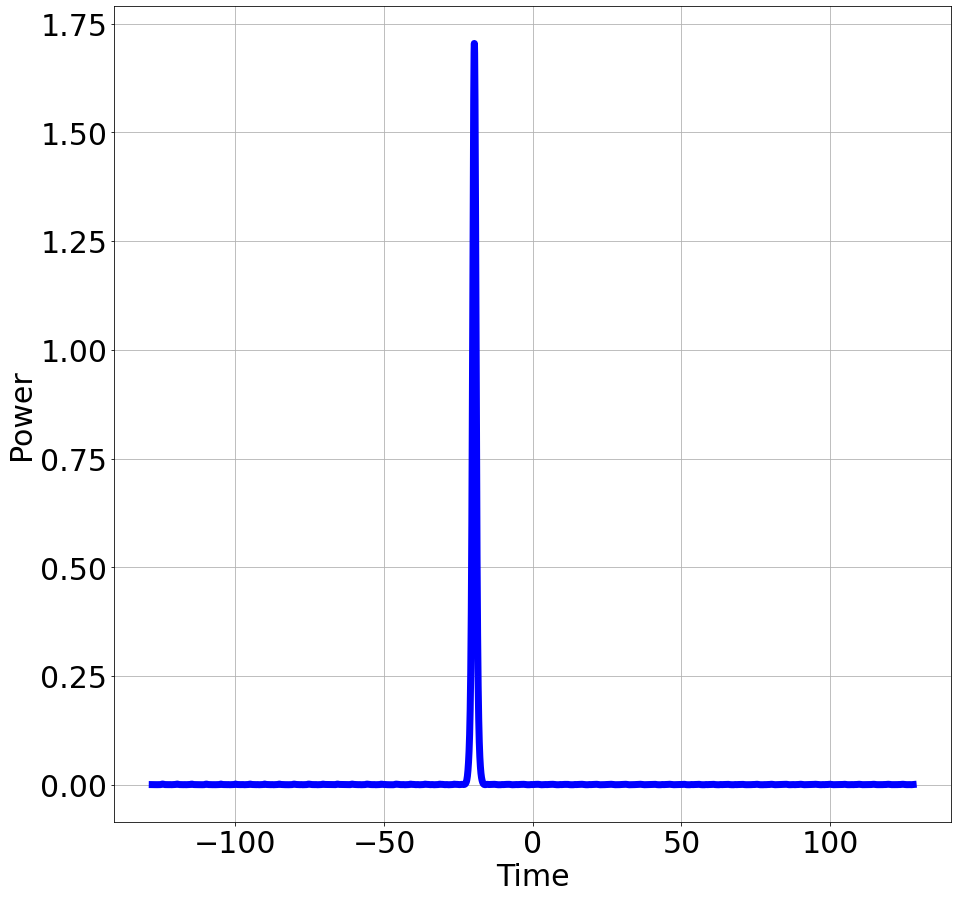

In [282]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t, np.power(np.absolute(q_fnft), 2), 'blue', linewidth=7)
# axs.set_xlim(-Tmax, Tmax)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

In [298]:
# ssfm propagation

n_t_prop = 2 ** 12
t_span_prop = 2 ** 9
t_prop = np.linspace(-t_span_prop, t_span_prop, n_t_prop)
q_for_prop = q_ampl * (5.2 / np.cosh(t_prop) + 1.2 / np.cosh((t_prop + 1) * 3) + 2.4 / np.cosh((t_prop - 1) * 3)) * np.exp(1j * 0.1 * t_prop)


q_prop = ssfm.fiber_propogate(q_for_prop, 2.0 * t_span_prop, z_prop, 2 ** 12, gamma=gamma, beta2=beta2)

<ipython-input-298-289b8e5543e6>:6: RuntimeWarning: overflow encountered in cosh
  q_for_prop = q_ampl * (5.2 / np.cosh(t_prop) + 1.2 / np.cosh((t_prop + 1) * 3) + 2.4 / np.cosh((t_prop - 1) * 3)) * np.exp(1j * 0.1 * t_prop)


In [39]:
# ssfm propagation
z_prop = 200.0
beta2 = -1.0
gamma = 1.0

n_z_prop = 2 ** 12
# n_t_prop = 2 ** 12
# t_span_prop = 2 ** 9
# t_prop = np.linspace(-t_span_prop, t_span_prop, n_t_prop)
# q_for_prop = q_ampl * (5.2 / np.cosh(t_prop) + 1.2 / np.cosh((t_prop + 1) * 3) + 2.4 / np.cosh((t_prop - 1) * 3))

t_prop = t
q_prop = ssfm.fiber_propogate(q, t_span, z_prop, n_z_prop, gamma=gamma, beta2=beta2)

In [74]:
q_total = np.concatenate((q_left_part[:len(t) // 2], np.conj(q_right_part[:len(t) // 2][::-1])))
# q_total_bid = np.concatenate((q_left_part_bid[:len(t) // 2], np.conj(q_right_part_bid[:len(t) // 2][::-1])))
# q_total = np.concatenate((np.conj(q_left_part[:len(t) // 2]), q_right_part[:len(t) // 2][::-1]))
# q_total = np.concatenate((q_left_part[:len(t) // 2], q_right_part[:len(t) // 2][::-1]))
diff = np.absolute(q - q_total)
# diff_bid = np.absolute(q_prop - q_total_bid)
print(np.mean(diff))
# print(np.mean(diff), np.mean(diff_bid))
print(np.max(diff))
# print(np.max(diff), np.max(diff_bid))

0.017321238750587303
0.08559041883609515


In [23]:
import nft_analyse as nft
reload(nft)

<module 'nft_analyse' from '/home/esf0/PycharmProjects/nn_essential/nft_analyse.py'>

In [40]:
result_dbp_nft = nft.make_dbp_nft(q_prop, t, z_prop, xi_upsampling=4)
# result_dbp_nft = nft.make_dbp_nft_two_intervals(q_prop, t, q_prop, t, z_prop,
#                                                 xi_upsampling_big=1, xi_upsampling_small=1,
#                                                 fnft_type_big=20, fnft_type_small=20,
#                                                 inverse_type='tib')
q_total = result_dbp_nft['q_total']
q_fnft = result_dbp_nft['q_fnft']

/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1
/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1
/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1
/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1
/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1
/home/esf0/nft_from_igor/FNFT/lib/libfnft.so.0.4.1


In [17]:
result_prop_nft = nft.make_dbp_nft(q, t, z_prop, xi_upsampling=4)
q_total_prop = result_prop_nft['q_total']
q_fnft_prop = result_prop_nft['q_fnft']

In [66]:
result_dbp_nft_inv = nft.make_dbp_nft(q_prop[::-1], t, z_prop, xi_upsampling=4)

In [69]:
q_total_inv = result_dbp_nft_inv['q_total']
q_fnft_inv = result_dbp_nft_inv['q_fnft']

PER: (0.0, 0)
BER: (0.0, 0)


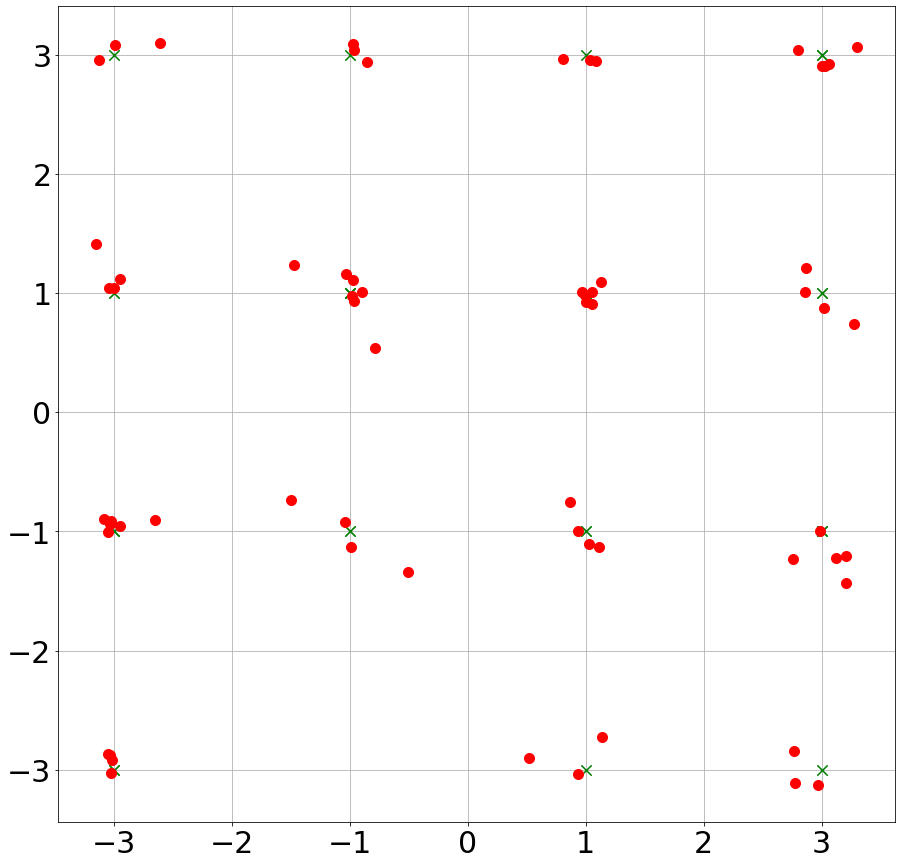

In [41]:
points_tib = constellation_scale * np.array(sg.get_points_wdm(q_total, t_symb, np_symb, None, None, n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral + n_add))
points_tib_found = sg.get_nearest_constellation_points(points_tib, mod_type)

print("PER:", sg.get_points_error_rate(points_orig, points_tib_found))
print("BER:", sg.get_ber_by_points(points_orig, points_tib_found, mod_type))


fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(np.real(points_orig), np.imag(points_orig), color='green', marker='x', markersize=10, linewidth=0)
axs.plot(np.real(points_tib), np.imag(points_tib), color='red', marker='o', markersize=10, linewidth=0)
# axs.plot(np.real(points_tib_to_scale[num_symb_d:num_symb_d + num_symb_proc]),
         # np.imag(points_tib_to_scale[num_symb_d:num_symb_d + num_symb_proc]),
         # color='blue', marker='o', markersize=12, linewidth=0)
# axs.plot(np.real(final_points_tib), np.imag(final_points_tib), color='blue', marker='*', markersize=12, linewidth=0)
# axs.plot(np.real(points_diff), np.imag(points_diff), color='green', marker='o', linewidth=0)
# axs.set_xlabel('Time')
# axs.set_ylabel('Power')
axs.grid(True)


In [19]:
# to find exact metric we have to delete n_lateral + n_add points first
# [n_add + n_lat : len(q) - (n_lat + n_add)]
# mse = (np.square(A - B)).mean(axis=ax)
#
# with ax=0 the average is performed along the row, for each column, returning an array
# with ax=1 the average is performed along the column, for each row, returning an array
# with ax=None the average is performed element-wise along the array, returning a scalar value


diff = np.absolute(q_prop - q_total_prop)
print(np.mean(diff))
print(np.max(diff))


diff = np.absolute(q_prop - q_fnft_prop)
print(np.mean(diff))
print(np.max(diff))

NameError: name 'q_total_prop' is not defined

In [42]:
diff = np.absolute(q - q_total)
print(np.mean(diff))
print(np.max(diff))


# diff = np.absolute(q - q_fnft)
# print(np.mean(diff))
# print(np.max(diff))
# 0.0003253404834141575
# 0.01451019756426208

0.00015393800469566758
0.014509593706601074


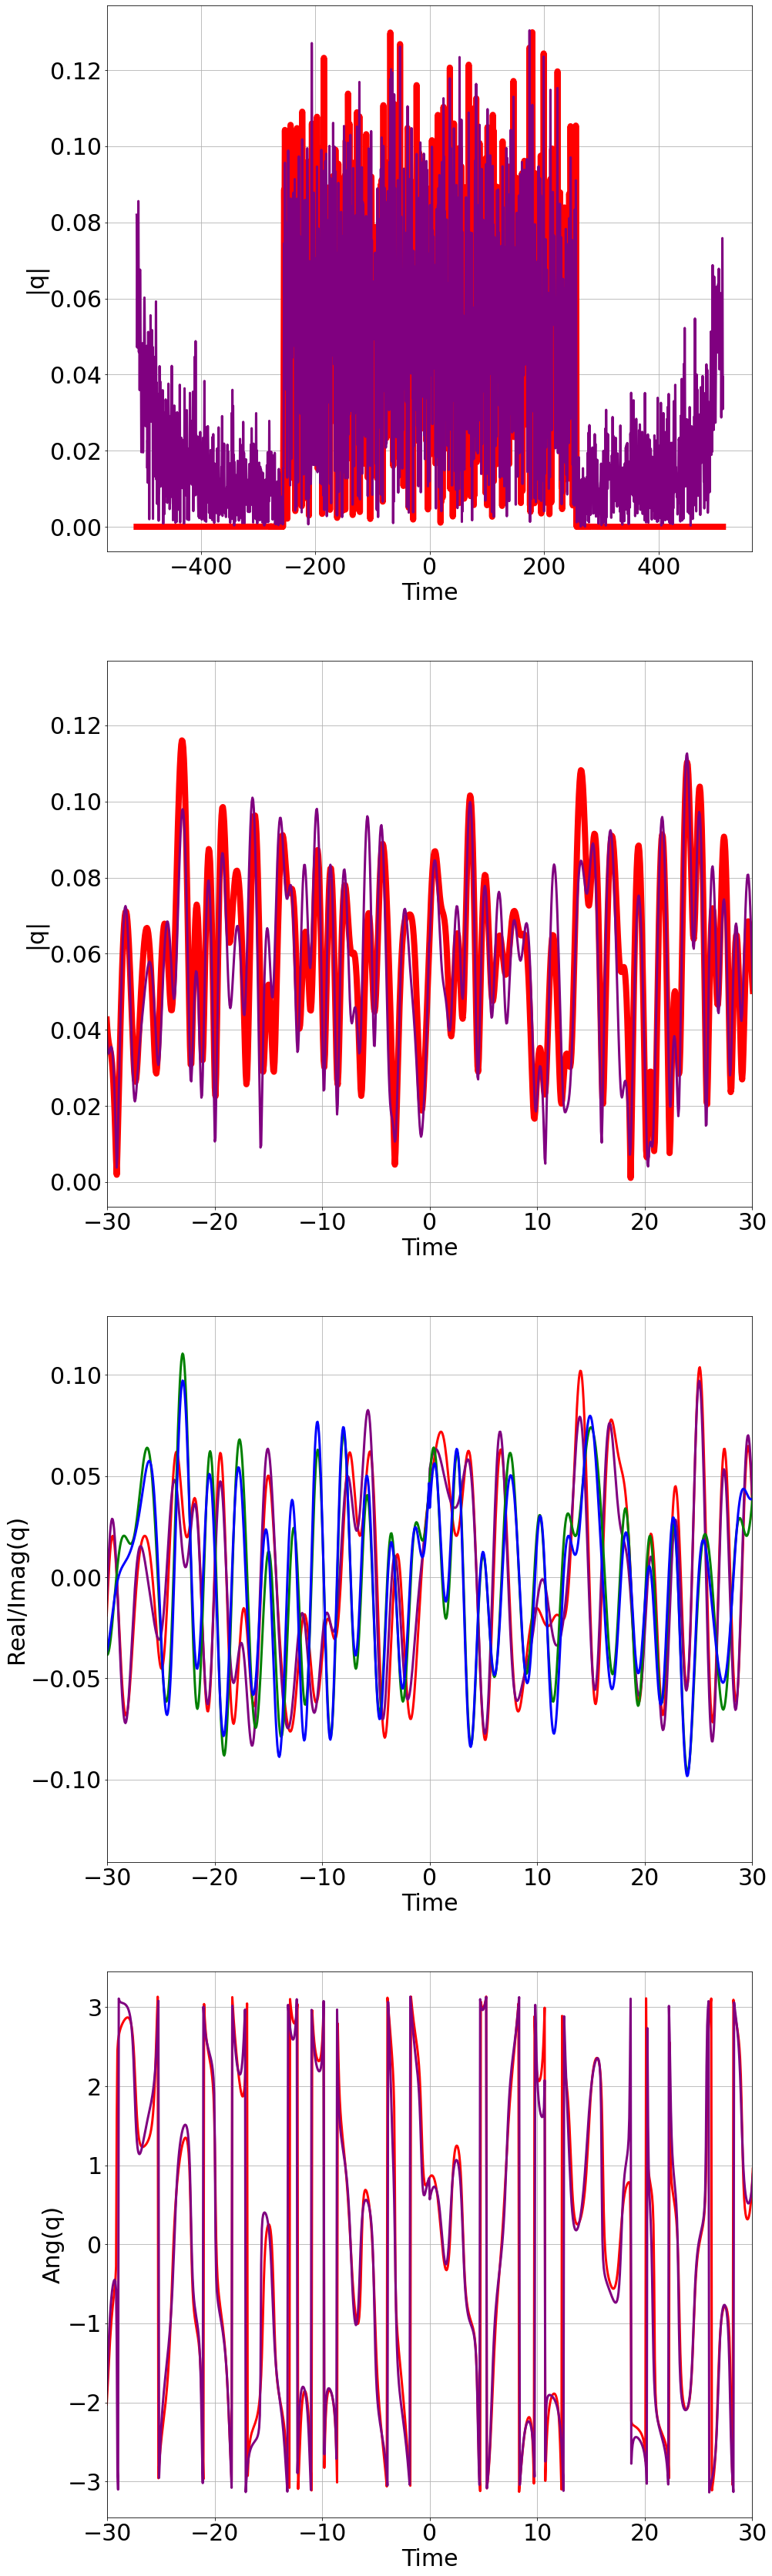

In [76]:
# coef_t_draw = 1. / 8 * coef_t  # for [-T; T]
# coef_t_draw = 1. / 2.0 * coef_t
coef_t_draw = 1.

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(4, 1, figsize=(15,60))
axs[0].plot(t, np.absolute(q), 'red', linewidth=8)
# axs[0].plot(t * coef_t_draw, np.absolute(q_fnft), 'green', linewidth=4)
axs[0].plot(t * coef_t_draw, np.absolute(q_total), 'purple', linewidth=3)
# axs[0].set_xlim(-30., 30.)
# ax.set_xlim(-t_span / 2., t_span / 2.)
# axs[0].set_ylim(0, 20)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('|q|')
axs[0].grid(True)

axs[1].plot(t, np.absolute(q), 'red', linewidth=8)
# axs[1].plot(t * coef_t_draw, np.absolute(q_fnft), 'green', linewidth=4)
axs[1].plot(t * coef_t_draw, np.absolute(q_total), 'purple', linewidth=3)
# axs[1].plot(t * coef_t_draw, np.absolute(q_total_inv[::-1]), 'xkcd:cyan', linewidth=3)
axs[1].set_xlim(-30, 30)
# axs[1].set_ylim(0, 20)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('|q|')
axs[1].grid(True)

axs[2].plot(t, np.real(q), 'red', linewidth=3)
axs[2].plot(t * coef_t_draw, np.real(q_total), 'purple', linewidth=3)
axs[2].plot(t, np.imag(q), 'green', linewidth=3)
axs[2].plot(t * coef_t_draw, np.imag(q_total), 'blue', linewidth=3)
axs[2].set_xlim(-30, 30)
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Real/Imag(q)')
axs[2].grid(True)

axs[3].plot(t, np.angle(q), 'red', linewidth=3)
axs[3].plot(t * coef_t_draw, np.angle(q_total), 'purple', linewidth=3)
axs[3].set_xlim(-30, 30)
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Ang(q)')
axs[3].grid(True)

# fig.savefig('../images/' + 'nft_1000km_' + str(num_symbols) + 'ts_5dbm' + '.pdf', format='pdf', bbox_inches='tight')

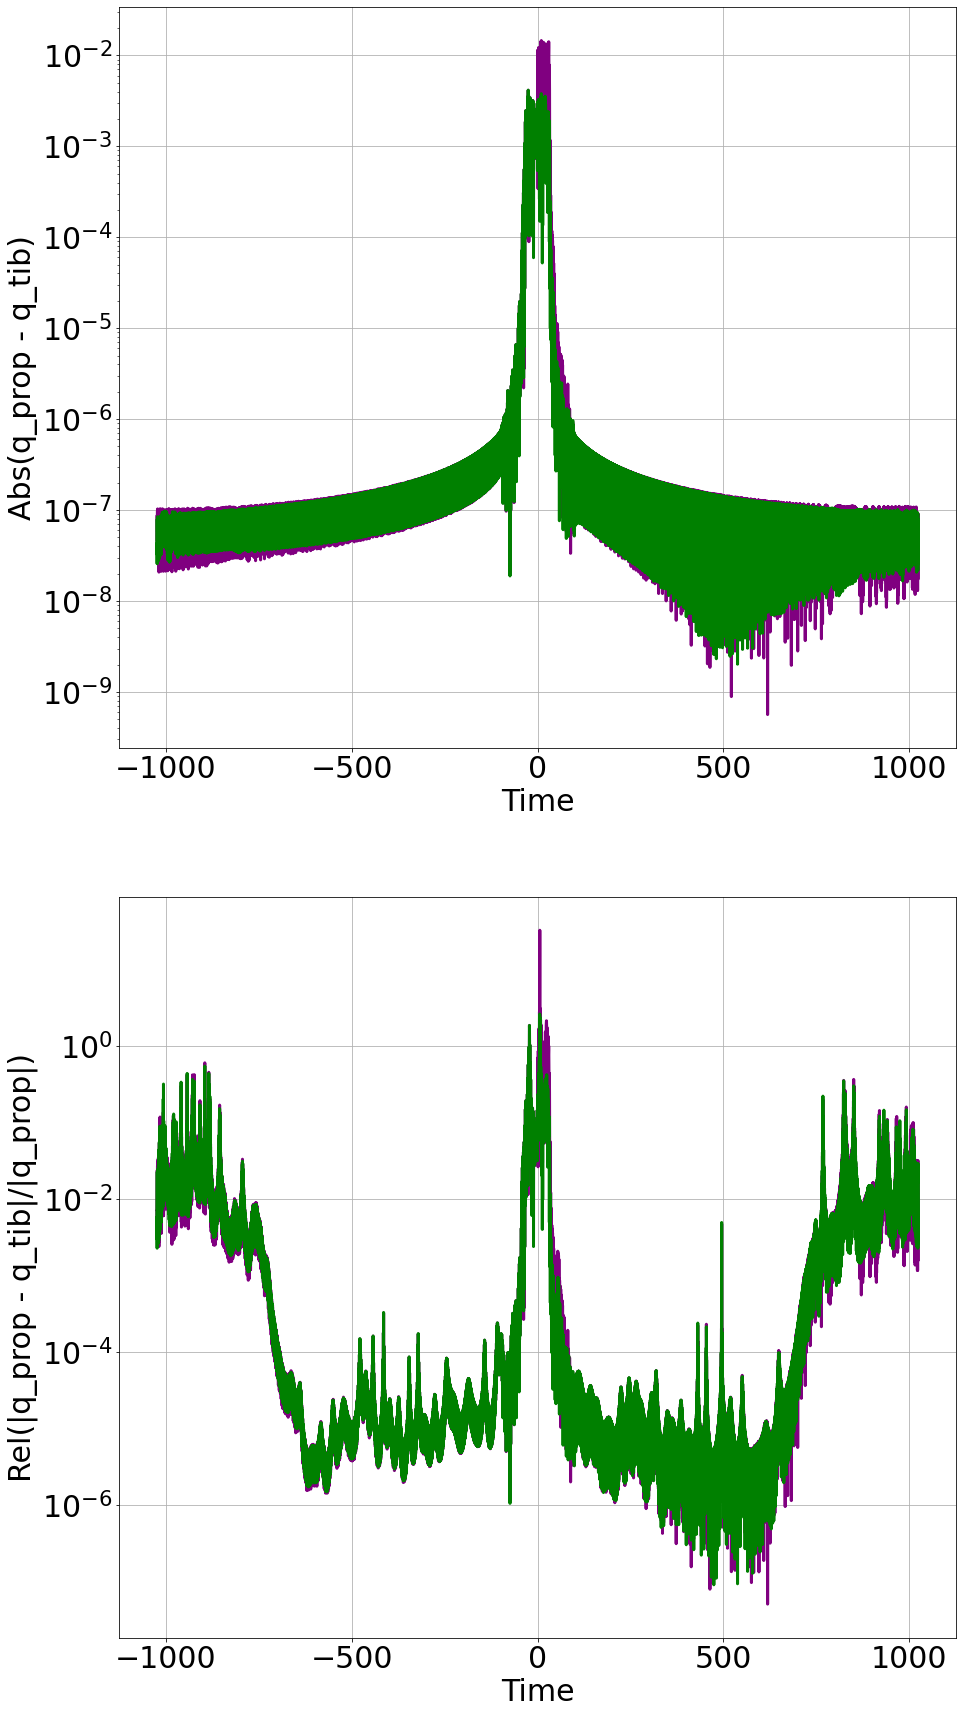

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(15,30))
axs[0].plot(t, np.absolute(q - q_total), 'purple', linewidth=3)
axs[0].plot(t, np.absolute(q - q_fnft), 'green', linewidth=3)
# axs.set_xlim(-5, 5)
axs[0].set_yscale('log')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Abs(q_prop - q_tib)')
axs[0].grid(True)

axs[1].plot(t, np.absolute(q - q_total) / np.absolute(q_prop), 'purple', linewidth=3)
axs[1].plot(t, np.absolute(q - q_fnft) / np.absolute(q_prop), 'green', linewidth=3)
# axs.set_xlim(-5, 5)
axs[1].set_yscale('log')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Rel(|q_prop - q_tib|/|q_prop|)')
axs[1].grid(True)


plt.show()

# fig.savefig('../images/' + 'nft_1000km_diff_' + str(num_symbols) + 'ts_5dbm' + '.pdf', format='pdf', bbox_inches='tight')

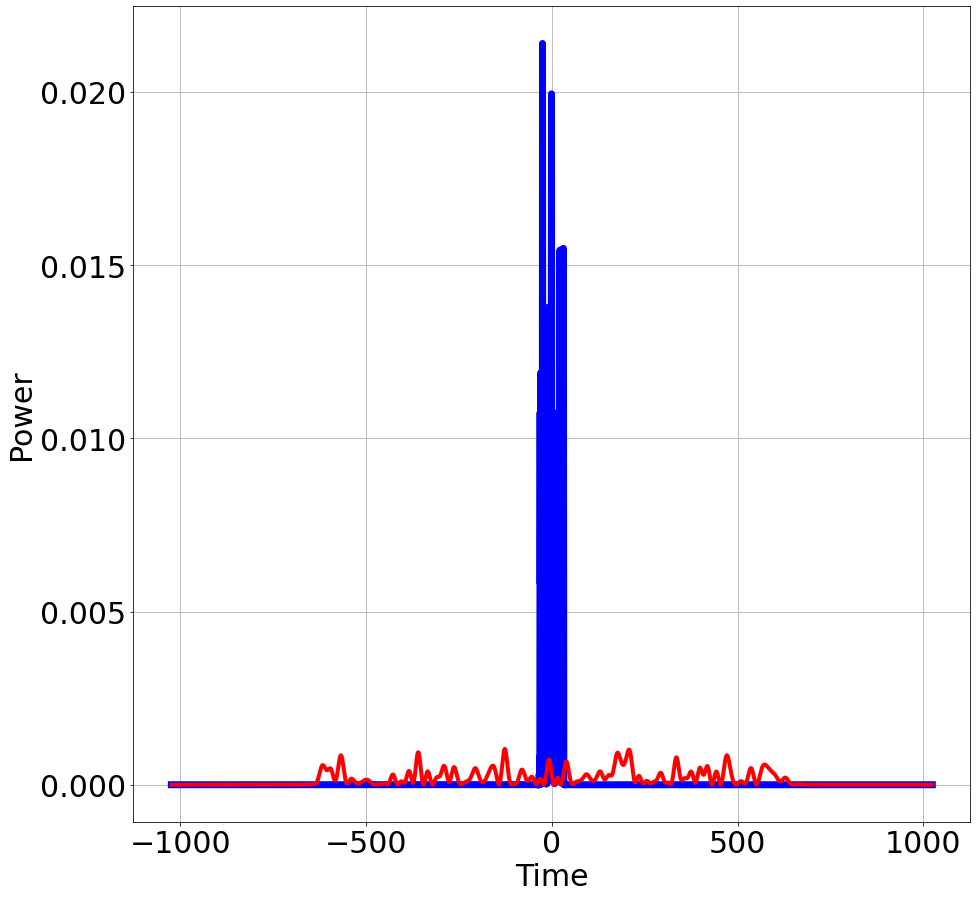

In [45]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t, np.power(np.absolute(q), 2), 'blue', linewidth=7)
axs.plot(t, np.power(np.absolute(q_prop), 2), 'red', linewidth=4)
# axs.set_xlim(-Tmax, Tmax)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)



old code


In [ ]:
q = 20.2 / np.cosh(tvec)

matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(tvec, np.power(np.absolute(q), 2), 'blue', linewidth=7)
axs.set_xlim(-Tmax, Tmax)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

In [149]:
beta2 = -1.0
gamma = 1.0
z_prop = 10

res = nsev(q, tvec, M=M, Xi1=xi[0], Xi2=xi[1], kappa=1)

cont_spec = res['cont_ref']
bound_states = res['bound_states']
disc_norm = res['disc_norm']

print(bound_states)

cont_spec_prop = cont_spec * np.exp(-2. * 1.0j * z_prop * np.power(np.array(xivec), 2))
disc_norm_prop = disc_norm * np.exp(-2. * 1.0j * z_prop * np.power(np.array(bound_states), 2))

res_prop = nsev_inverse(xivec, tvec, cont_spec_prop, bound_states, disc_norm_prop, cst=0, dst=0)

signal_prop = fiber_propogate(q, 2 * Tmax, z_prop, 2 ** 10, gamma=gamma, beta2=beta2)
res_ssfm = nsev(signal_prop, tvec, M=M, Xi1=xi[0], Xi2=xi[1], kappa=1)

cont_spec_ssfm = res_ssfm['cont_ref']
bound_states_ssfm = res_ssfm['bound_states']
disc_norm_ssfm = res_ssfm['disc_norm']

print(bound_states_ssfm)
# print(get_energy(q, Tmax * 2))

[-2.93873588e-39+19.69982798j -1.04692466e-38+18.69984504j
 -3.15544362e-30+16.69987648j  2.86985925e-42+17.69986121j
  4.82136355e-40+14.69990434j  5.56035231e-41+15.69989086j
 -1.11671963e-37+12.69992863j  7.70371978e-34+13.69991693j
  3.76158192e-36+10.69994935j -8.93375707e-37+11.69993943j
  1.27893785e-35 +8.69996653j -7.57306469e-29 +9.69995838j
 -7.22223729e-34 +7.69997378j -1.65509605e-35 +6.69998015j
  4.93038066e-31 +5.69998564j  4.43734259e-31 +4.69999023j
 -1.92592994e-33 +3.69999395j -3.76158192e-37 +2.69999678j
  1.74487443e-39 +1.69999872j  4.48853414e-46 +0.69999978j]
[10.03770799+31.10546712j 35.26019794+15.70294676j
 46.75759308 +0.09268702j  7.59898081+29.92122276j
  8.87134852+28.14552674j 18.8418536 +21.15325512j
  9.70889941+25.85231605j 43.98459407 +0.09016803j
  8.75056737+27.29911117j 20.38089889+17.61810514j
  7.06306478+24.53366233j  4.53764253+23.4482596j
  4.19686302+21.79479773j 13.54201291+20.08445115j
 40.45689943 +0.04616948j 14.58044647+22.22152725j
  

[-1.69653943e+01+27.25592935j  1.70031946e+01+27.25198273j
  1.76880887e+01+24.85786313j -1.74950058e+01+24.71068226j
  1.78544447e+01+20.40684789j  1.83143453e+00+87.66976282j
 -6.27634684e-02+20.72954353j -1.57494966e-06+15.18536072j
  4.67844214e+00+10.4461623j   1.11513150e-07+12.71345417j
 -9.46199279e-07+10.67611639j  4.39160026e-01 +9.29401608j
 -5.21840139e+00 +8.6823068j   4.34138844e-07 +7.67688333j
  1.06864445e-03 +6.94586148j -4.98689708e-05 +4.7030239j
 -1.00423032e-01 +4.68521942j  1.07556858e-04 +2.7267735j
 -9.78474290e-05 +1.69149861j  6.48194609e-05 +0.6928779j ]


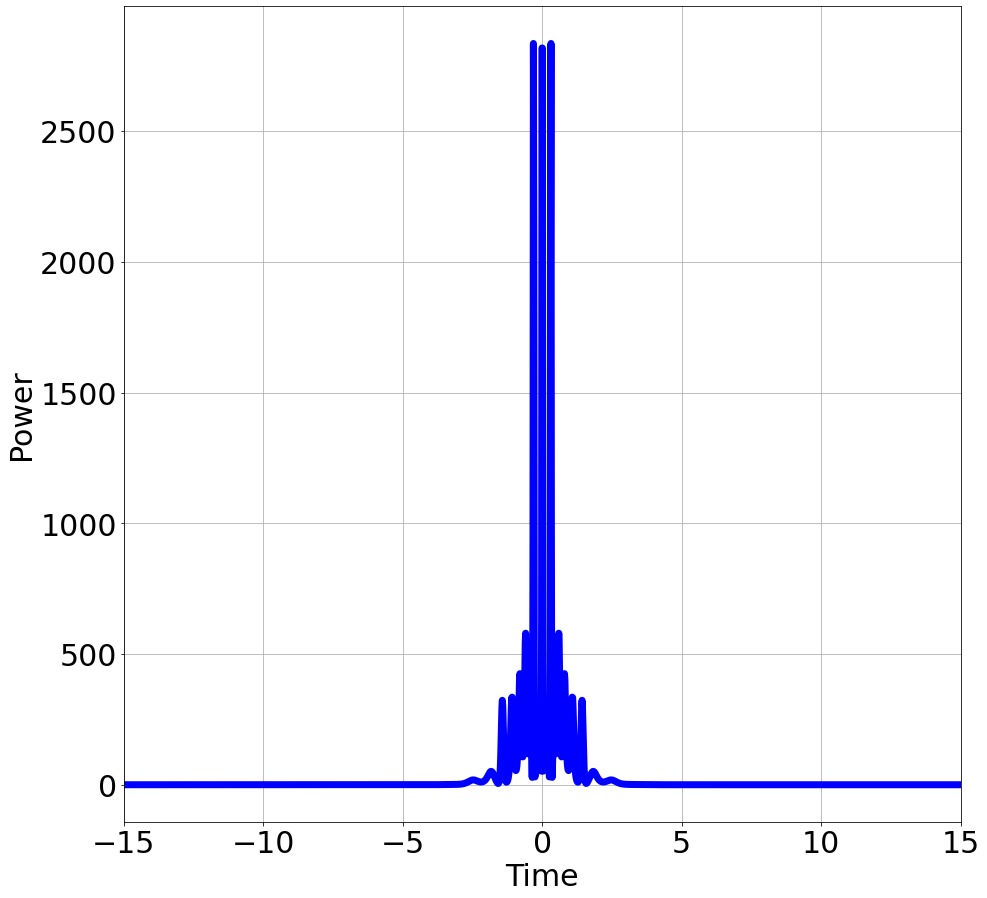

In [150]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(tvec, np.power(np.absolute(res_prop['q']), 2), 'blue', linewidth=7)
axs.set_xlim(-Tmax, Tmax)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

res_test = nsev(res_prop['q'], tvec, M=M, Xi1=xi[0], Xi2=xi[1], kappa=1)
print(res_test['bound_states'])

<ipython-input-153-35c9aef10799>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


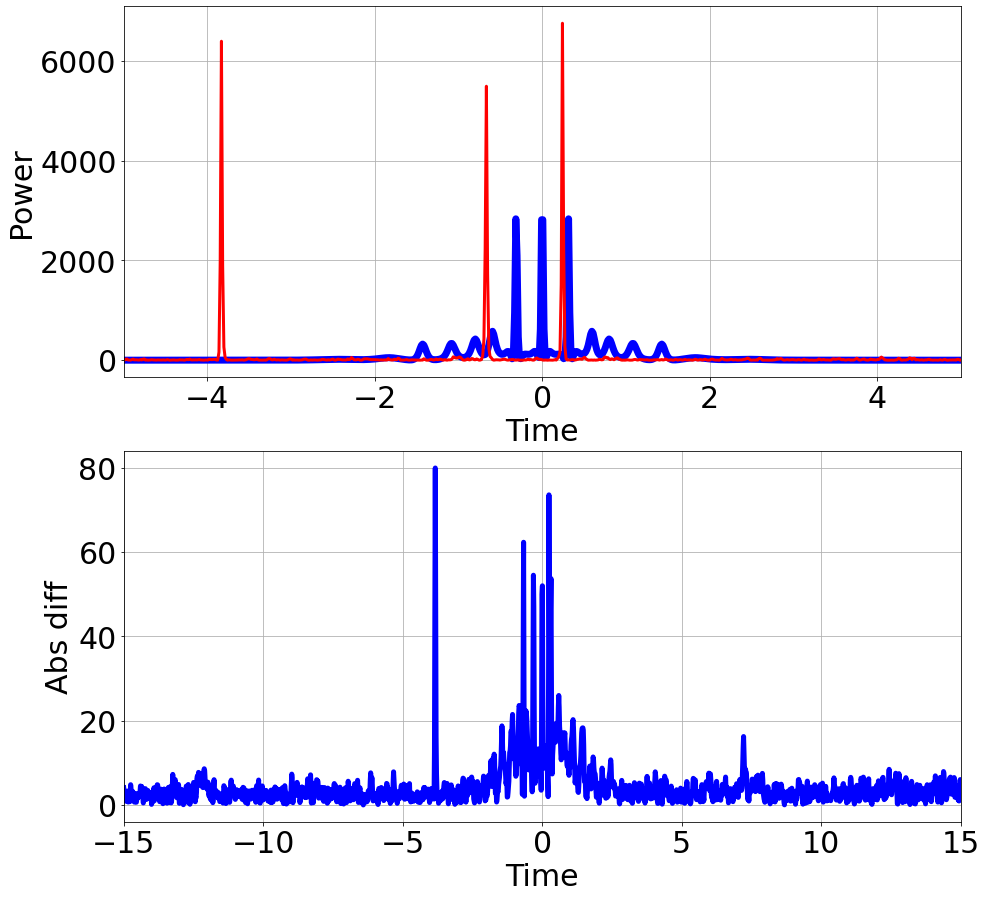

In [153]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(tvec, np.power(np.absolute(res_prop['q']), 2), 'blue', linewidth=7)
axs[0].plot(tvec, np.power(np.absolute(signal_prop), 2), 'red', linewidth=3)
axs[0].set_xlim(-Tmax, Tmax)
# axs[0].set_ylim(0, 0.5)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(tvec, np.absolute(res_prop['q'] - signal_prop), 'blue', linewidth=5)
axs[1].set_xlim(-Tmax, Tmax)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Abs diff')
axs[1].grid(True)

fig.show()

<ipython-input-152-297e3c15024b>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


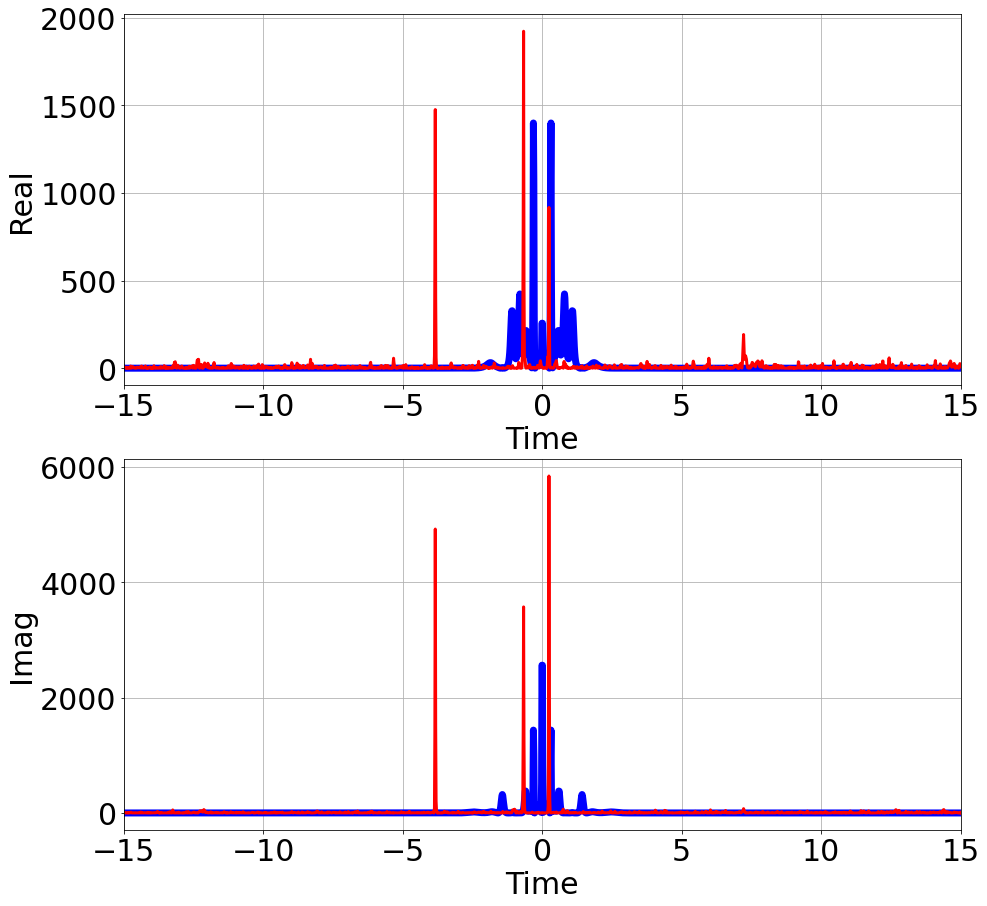

In [152]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(tvec, np.power(np.real(res_prop['q']), 2), 'blue', linewidth=7)
axs[0].plot(tvec, np.power(np.real(signal_prop), 2), 'red', linewidth=3)
axs[0].set_xlim(-Tmax, Tmax)
# axs[0].set_ylim(0, 0.5)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Real')
axs[0].grid(True)

axs[1].plot(tvec, np.power(np.imag(res_prop['q']), 2), 'blue', linewidth=7)
axs[1].plot(tvec, np.power(np.imag(signal_prop), 2), 'red', linewidth=3)
axs[1].set_xlim(-Tmax, Tmax)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Imag')
axs[1].grid(True)

fig.show()

<ipython-input-122-3ae8251281cb>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


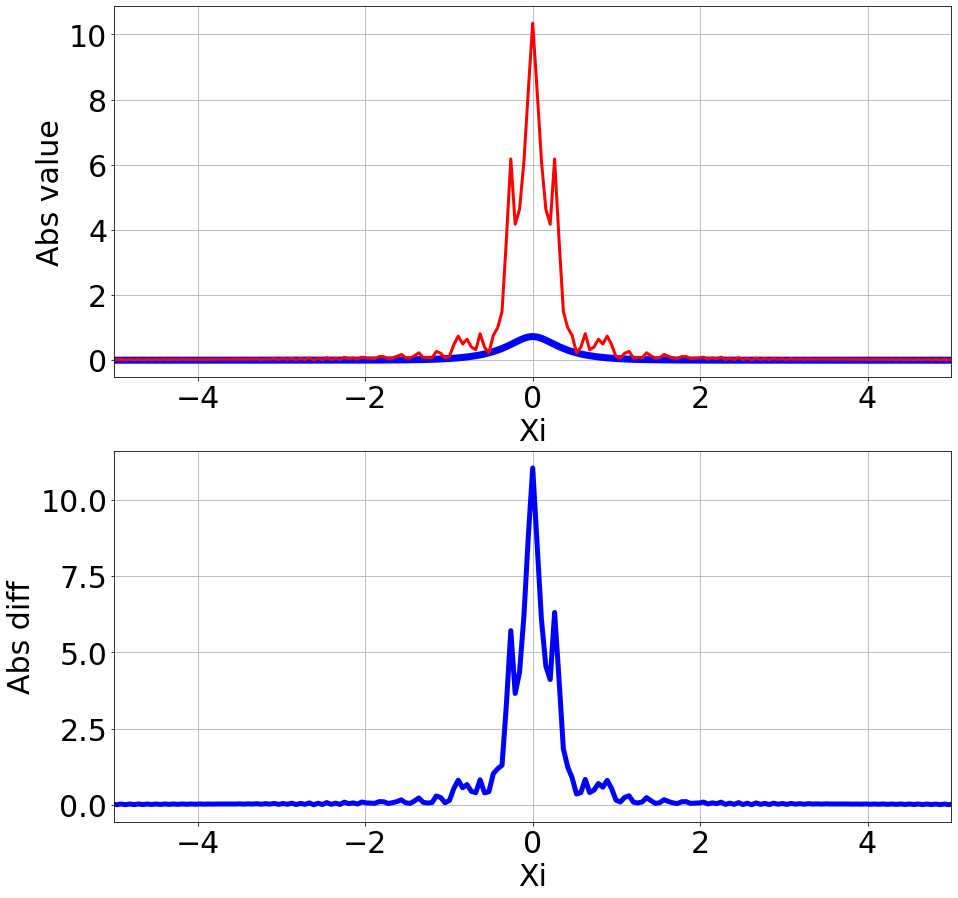

In [122]:
matplotlib.rcParams.update({'font.size': 30})

xilim = 5

fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(xivec, np.absolute(cont_spec_prop), 'blue', linewidth=7)
axs[0].plot(xivec, np.absolute(cont_spec_ssfm), 'red', linewidth=3)
axs[0].set_xlim(-xilim, xilim)
# axs[0].set_ylim(0, 0.5)
axs[0].set_xlabel('Xi')
axs[0].set_ylabel('Abs value')
axs[0].grid(True)

axs[1].plot(xivec, np.absolute(cont_spec_prop - cont_spec_ssfm), 'blue', linewidth=5)
axs[1].set_xlim(-xilim, xilim)
axs[1].set_xlabel('Xi')
axs[1].set_ylabel('Abs diff')
axs[1].grid(True)

fig.show()


In [ ]:
# signal parameters
mod_type = "16qam"
n_car = 1
t_symb = 1.

num_symbols = 64
np_symb = 8
n_lateral = 4 * np_symb
p_ave = 0.74
roll_off = 0.1
calc_type = 1

dt = t_symb / n_symb

# generate bit sequence
n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
random.seed(0)
bits = random.getrandbits(n_bits)
data = "{0:b}".format(int(bits))
if len(data) < n_bits:
    data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

# create signal and set power
signal = sg.get_wdm_signal(data, t_symb, n_symb, sg.rcos, [t_symb, roll_off],
                           n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
signal = sg.set_average_power(signal, dt, p_ave)

# create time and spectrum
n_signal = len(signal)
t = np.array([(i - n_signal / 2) * dt for i in range(n_signal)])
t_span = t[-1] - t[0]
xi_span = np.pi / (2. * dt)
dxi = xi_span / n_signal
xi = np.linspace(-xi_span / 2., xi_span / 2. - dxi, n_signal)

bsl = 2
if calc_type == 1 or calc_type >= 22:
    bsl = 1

# start = time.time()
res = nsev(signal, t, M=n_signal, Xi1=-xi_span / 2., Xi2=xi_span / 2. - dxi, bsl=bsl, dis=calc_type, kappa=1)
cont_spec_init = res['cont_ref']
# end = time.time()
print("Calc type ", calc_type)
# print("Elapsed = %s" % (end - start))




In [ ]:
# # save results
# result_dict = {'num_symbols': num_symbols,
#              'n_symb': n_symb,
#              't_symb': t_symb,
#              'n_lateral': n_lateral,
#              'p_ave': p_ave,
#              'roll_off': roll_off,
#              'calc_type': calc_type,
#              'mod_type': mod_type,
#              'n_car': n_car,
#              'result': result,
#              'calc_time': calc_time}
# df = df.append(result_dict, ignore_index=True)
# df.to_pickle("nft_signal_results.pkl")


In [ ]:

beta2 = -1.0
gamma = 1.0
z_prop = 1.0


signal_prop = fiber_propogate(signal, t_span, z_prop, 2 ** 14, gamma=gamma, beta2=beta2)
res_prop = nsev(signal, t, M=n_signal, Xi1=-xi_span / 2., Xi2=xi_span / 2. - dxi, bsl=bsl, dis=calc_type, kappa=1)
cont_spec_prop = res_prop['cont_ref']
# energy_end = get_energy(signal_prop, t_span)

# band = 2 * np.pi
# n = len(signal)
# dw = band / t_span
# w = np.array([(i - nt / 2) * (2. * np.pi / t_span) for i in range(nt)])

# --- Plot input pulse shape and spectrum
# spect = np.power(np.abs(fftshift(fft(signal))), 2)  # input spectrum of Fourier transform
# spect = spect / np.max(spect)  # normalize
# freq = fftshift(w) / (2 * np.pi)  # freq. array
# freq = w / (2 * np.pi)  # freq. array

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(t, np.power(np.absolute(signal), 2), 'blue')
axs[0].plot(t, np.power(np.absolute(signal_prop), 2), 'red')
axs[0].set_xlim(-t_span / 2, t_span / 2)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(freq, spect, 'blue')
axs[1].plot(freq, np.power(np.abs(fftshift(fft(signal_prop))), 2), 'red')
# axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
axs[1].set_xlim(-1, 1)
axs[1].set_xlabel('Normalized Frequency')
axs[1].set_ylabel('Spectral Power')
axs[1].grid(True)

fig.show()

fig2, axs2 = plt.subplots(3, 1)
axs2[0].plot(t, np.power(np.absolute(signal_prop), 2), 'blue')
axs2[0].plot(t, np.power(np.absolute(signal_end), 2), 'red')
axs2[0].set_xlim(-t_span / 2, t_span / 2)
axs2[0].set_xlabel('Time')
axs2[0].set_ylabel('Power')
axs2[0].grid(True)

axs2[1].plot(freq, np.power(np.abs(fftshift(fft(signal_prop))), 2), 'blue')
axs2[1].plot(freq, np.power(np.abs(fftshift(fft(signal_end))), 2), 'red')
# axs2[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
axs2[1].set_xlim(-5, 5)
axs2[1].set_xlabel('Normalized Frequency')
axs2[1].set_ylabel('Spectral Power')
axs2[1].grid(True)

axs2[2].plot(t, np.absolute(signal_prop - signal_end), 'blue')
axs2[2].set_xlim(-t_span / 2, t_span / 2)
axs2[2].set_xlabel('Time')
axs2[2].set_ylabel('Power')
axs2[2].set_yscale('log')
axs2[2].grid(True)